<a href="https://colab.research.google.com/github/JonasZaoui/Detecting-Covid-19-with-Chest-X-Ray-using-Pytorch/blob/main/Detecting_COVID_19_with_Chest_X_Ray_using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)


## Préparation du Training Set et du Test Set 

Objectif : Obtenir les dossiers Covid, Normal, Test, viral, et les fichers xls à part 

Le dossier test set contient 3 dossiers : covid, normal, viral, avec 30 images dans chacun des dossiers. 

Exemple d'une image de Normal 
/content/drive/MyDrive/covid19_database/COVID-19_Radiography_Dataset/Normal/Normal-10094.png


In [4]:
class_names = ['normal','viral','covid'] #Dossiers/Classes qu'on veut obtenir
root_dir = '/content/drive/MyDrive/covid19_database/COVID-19_Radiography_Dataset' #path du dataset
source_dirs = ['Normal', 'Viral Pneumonia', 'COVID'] #dossiers qu'on a actuellement


if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i])) #On renomme les dossiers qu'on a 

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c)) #On créée nos 3 dossiers du dossier TEST. root_dir/test/xxxx

    for c in class_names:

        #je recupere toutes les images PNG de la classe c 
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')] 

        #je selectionne 30 images parmi cet échantillon
        selected_images = random.sample(images, 30)

        for image in selected_images :  #je parcours les 30 images qu'on veut deplacer 
          source_path = os.path.join(root_dir,c,image) #lien de l'image 
          target_path = os.path.join(root_dir,'test',c,image) 
          shutil.move(source_path, target_path) #On déplace l'image de la source vers la target 


#Pas besoin de Rerunner 


## Création de la classe Dataset personnalisée

In [35]:
class ChestXRayDataset(torch.utils.data.Dataset):
  def __init__(self,image_dirs,transform):
    # image_dirs = dictionnaire contenant pour clés nos classes, et en valeurs les path de chaque classe 

    def get_images(class_name): #Fonction qu'on va utiliser dans le constructeur, se fait automatiquement 
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images #Retourne liste des images 
        
    self.images = {} #création du dictionnaire ou on mettra toutes les images avec les classes pour clés. 
    self.class_names = ['normal', 'viral', 'covid']
        
    for class_name in self.class_names:
        self.images[class_name] = get_images(class_name) #appel de la fonction 
            
    self.image_dirs = image_dirs 
    self.transform = transform


  def __len__(self): #TOUJOURS METTRE CETTE FONCTION
    #Retourne la sommme des longueurs des valeurs du dictionnaire crée
    return sum([len(self.images[class_name]) for class_name in self.class_names]) 


  def __getitem__(self,index): #index d'une classe au hasard. TOUJOURS METTRE CETTE FONCTION
    class_name = random.choice(self.class_names)  
    index = index % len(self.images[class_name]) #On divise pour pas que l'index depasse le nb d'images de la classe
    image_name = self.images[class_name][index] # On récupère le nom de la classe, puis l'index c'est la position. On obtient le path de l'image
    image_path = os.path.join(self.image_dirs[class_name],image_name) 
    image = Image.open(image_path).convert('RGB') #On ouvre, et convertit en RGB 
    return self.transform(image),self.class_names.index(class_name) 
   

## Transformations 

In [36]:
#Transformation du training set 
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#Transformation du test set 
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])




## Préparation du DataLoader 

En argument du DataLoader, on a besoin d'un dataset, et du batch size 

In [37]:
train_dirs = {
    'normal': '/content/drive/MyDrive/covid19_database/COVID-19_Radiography_Dataset/normal',
    'viral': '/content/drive/MyDrive/covid19_database/COVID-19_Radiography_Dataset/viral',
    'covid': '/content/drive/MyDrive/covid19_database/COVID-19_Radiography_Dataset/covid'
}


train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 10162 normal examples
Found 1315 viral examples
Found 3586 covid examples


In [38]:
test_dirs = {
    'normal': '/content/drive/MyDrive/covid19_database/COVID-19_Radiography_Dataset/test/normal',
    'viral': '/content/drive/MyDrive/covid19_database/COVID-19_Radiography_Dataset/test/viral',
    'covid': '/content/drive/MyDrive/covid19_database/COVID-19_Radiography_Dataset/test/covid',
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [39]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dl_train)) #len(dataloader) depend de notre __len__ de la classe dataset
print('Number of test batches', len(dl_test))

Number of training batches 2511
Number of test batches 15


## Data Visualisation

In [58]:
class_names = train_dataset.class_names


def show_images(images, labels, preds):
    plt.figure(figsize=(16, 8))
    for i, image in enumerate(images): #on parcours les images du batch
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0)) #on transpose car la data transformation a rendu en Canal x Longueur x Largeur
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean # On dénormalize 
        image = np.clip(image, 0., 1.) 
        plt.imshow(image) #On affiche l'image
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

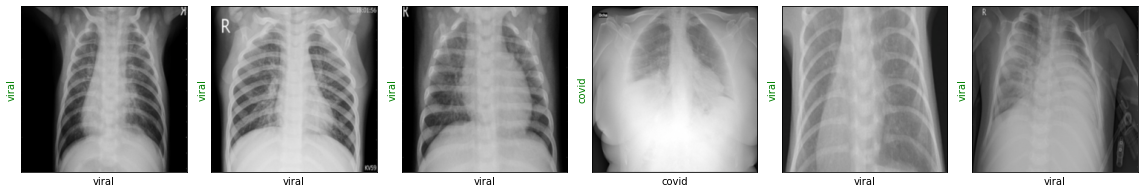

In [59]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

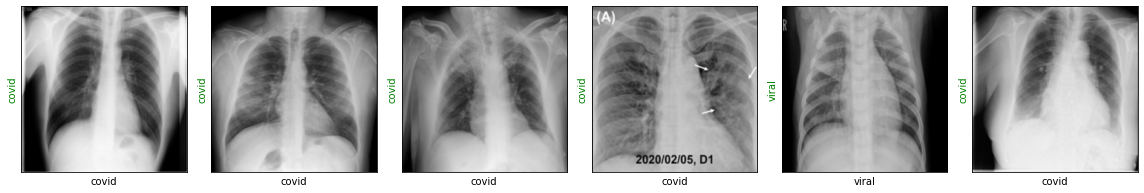

In [47]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

## Création du model 

In [53]:
resnet18 = torchvision.models.resnet18(pretrained=True)

print(resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [55]:
#J'accède à la derniere couche fully connected 
#Je met 3 car on a 3 classes possibles dans notre cas 
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3) 

#Cross-entropy loss, or log loss, measures the performance of a classification 
#model whose output is a probability value between 0 and 1
loss_fn = torch.nn.CrossEntropyLoss()

#Optimizer Adam 
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [56]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test)) #On récupere le premier batch de 6 images mélangées 
    outputs = resnet18(images)  #Resultats de 3 probabilités pour chacune des 6 images du batch
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

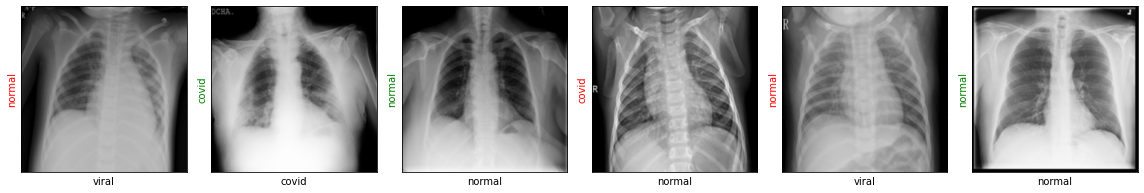

In [60]:
show_preds()

In [69]:
images, labels = next(iter(dl_test)) #On récupere le premier batch de 6 images mélangées 
outputs = resnet18(images)  #Resultats de 3 probabilités pour chacune des 6 images du batch

#torch.max(outputs,1) retourne 2 choses : 
# la valeur max selon les colonnes (d'ou le 1)
# l'indice de cette valeur max  
_, preds = torch.max(outputs, 1) 

In [79]:
labels #pour une image d'un batch  

tensor([0, 0, 2, 0, 1, 2])

In [71]:
outputs 

tensor([[ 0.9980, -0.8864, -0.2925],
        [ 0.2889, -0.9037,  0.3220],
        [ 0.9204, -0.9291, -0.2028],
        [ 0.7185, -0.8354,  0.1549],
        [ 0.5024, -0.8479,  0.3844],
        [ 0.1576, -0.9721,  0.6752]], grad_fn=<AddmmBackward0>)

In [73]:
torch.max(outputs,1)

torch.return_types.max(values=tensor([0.9980, 0.3220, 0.9204, 0.7185, 0.5024, 0.6752],
       grad_fn=<MaxBackward0>), indices=tensor([0, 2, 0, 0, 0, 2]))

## Entrainement du modèle 

In [74]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images) #predictions de notre model 
            loss = loss_fn(outputs, labels) #calcul de la perte 
            loss.backward() #on calcule les dérivées 
            optimizer.step() #mise a jour des parametres 
            train_loss += loss.item() 
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase
                
                #je fais mes predictions au fur et a mesure que je passe dans les batchs
                #pour constater l'amelioration quand je serai a la fin de l'epoch
                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1) #on recupere l'indice de l'element max 
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                resnet18.train()

                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

Starting training..
Starting epoch 1/1
Evaluating at step 0
Validation Loss: 1.3347, Accuracy: 0.3333


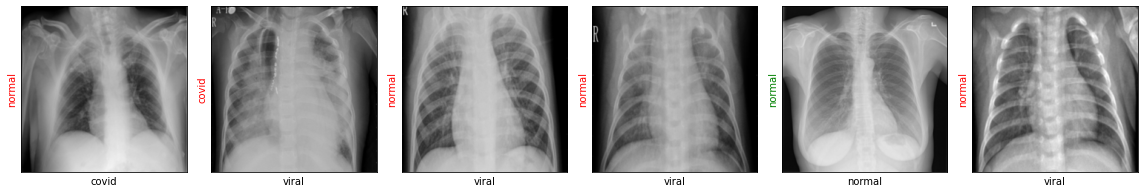

Evaluating at step 20
Validation Loss: 1.1155, Accuracy: 0.5000


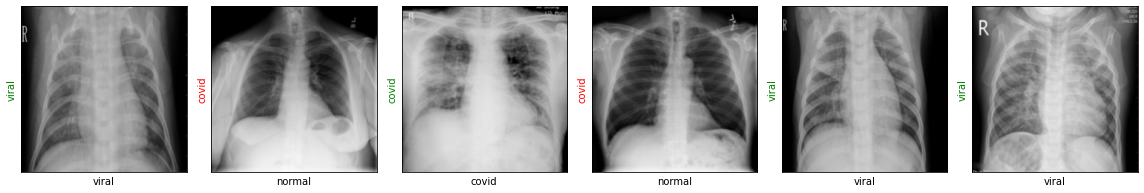

Evaluating at step 40
Validation Loss: 0.7866, Accuracy: 0.6778


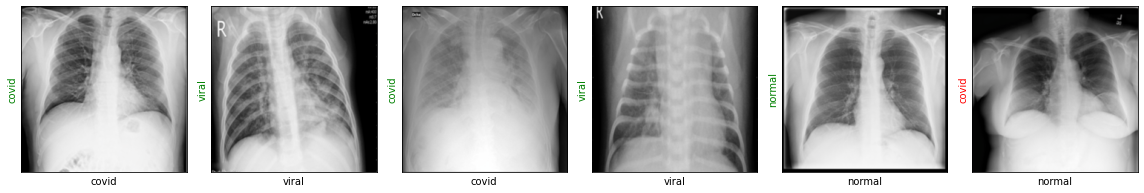

Evaluating at step 60
Validation Loss: 0.5132, Accuracy: 0.7889


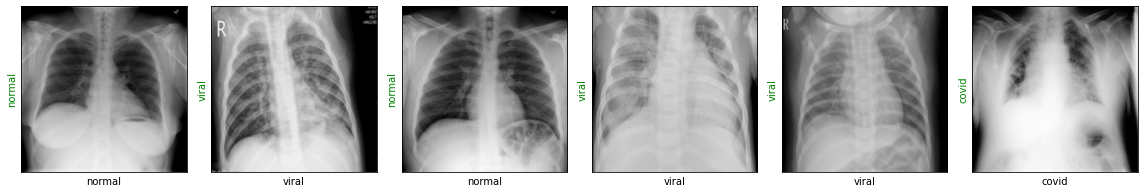

Evaluating at step 80
Validation Loss: 0.4156, Accuracy: 0.8556


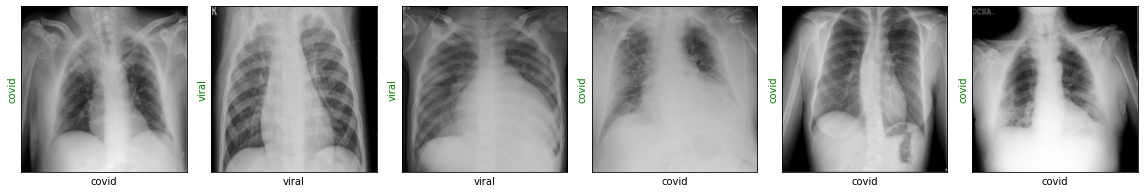

Evaluating at step 100
Validation Loss: 0.3995, Accuracy: 0.8778


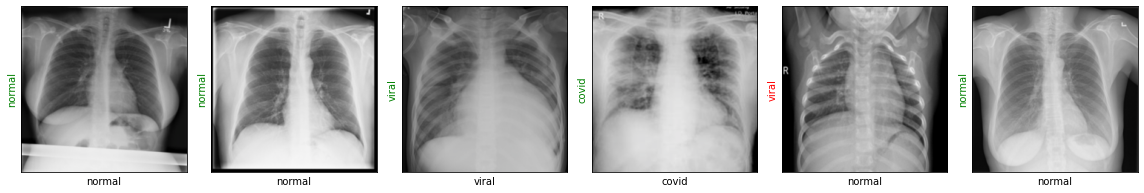

Evaluating at step 120
Validation Loss: 0.3221, Accuracy: 0.8556


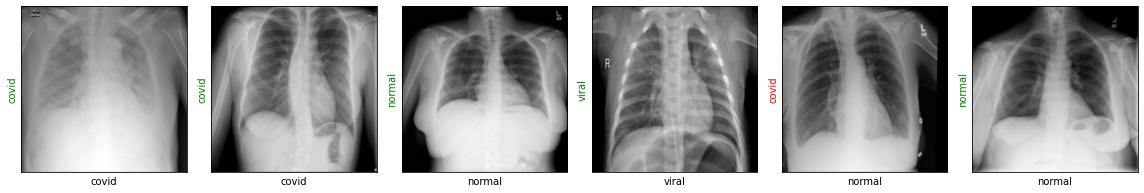

Evaluating at step 140
Validation Loss: 0.3401, Accuracy: 0.8667


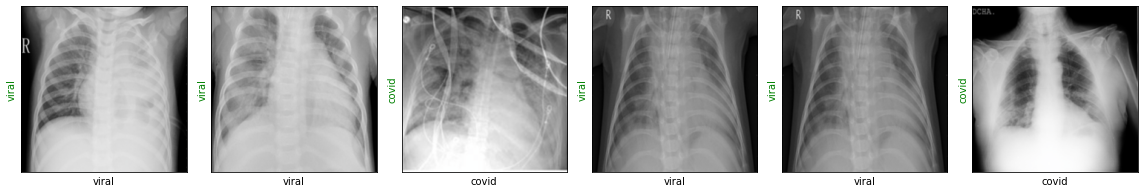

Evaluating at step 160
Validation Loss: 0.2484, Accuracy: 0.8889


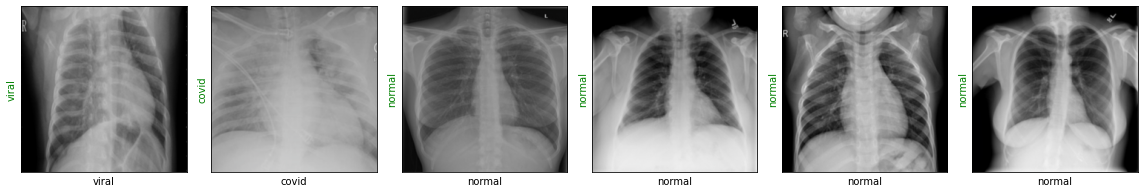

Evaluating at step 180
Validation Loss: 0.2423, Accuracy: 0.9000


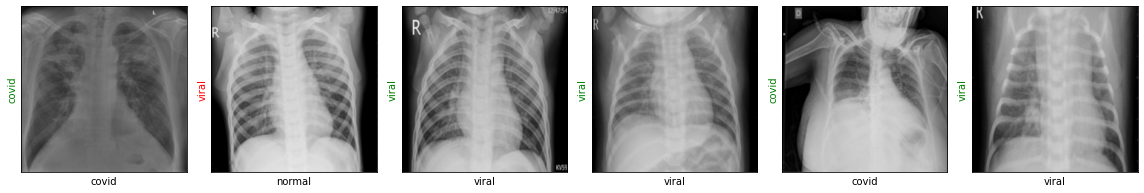

Evaluating at step 200
Validation Loss: 0.2277, Accuracy: 0.8889


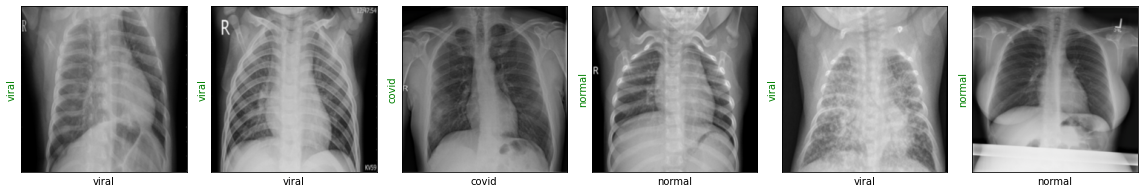

Evaluating at step 220
Validation Loss: 0.2498, Accuracy: 0.8889


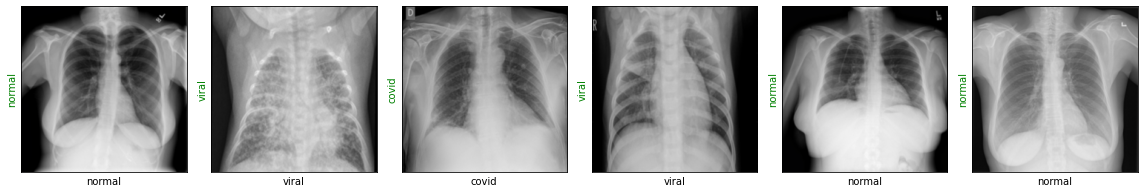

Evaluating at step 240
Validation Loss: 0.1877, Accuracy: 0.9333


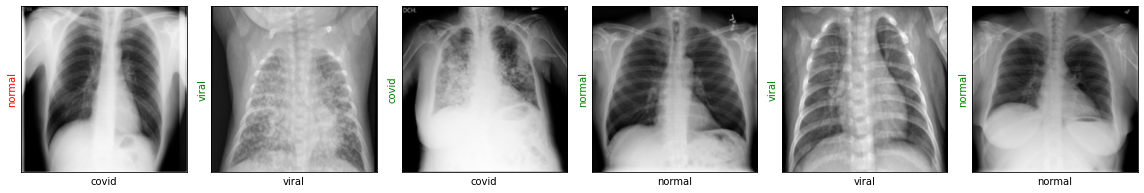

Evaluating at step 260
Validation Loss: 0.1930, Accuracy: 0.9444


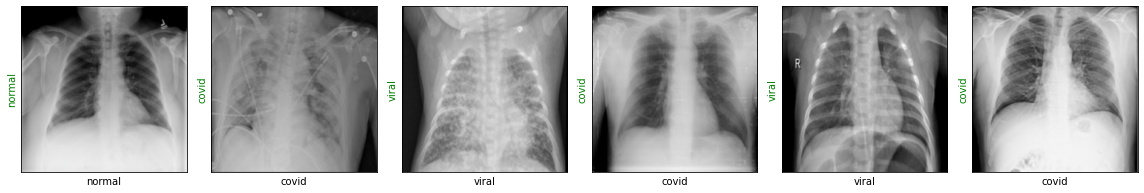

Evaluating at step 280
Validation Loss: 0.1635, Accuracy: 0.9444


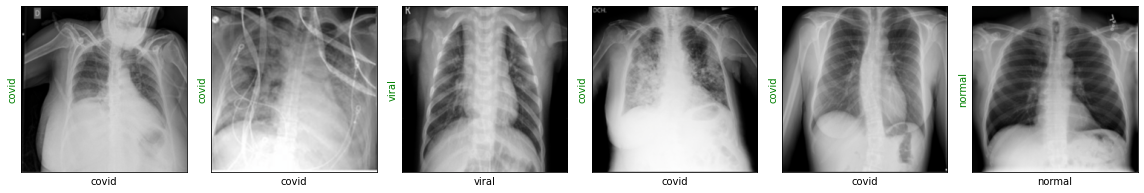

Evaluating at step 300
Validation Loss: 0.2372, Accuracy: 0.9222


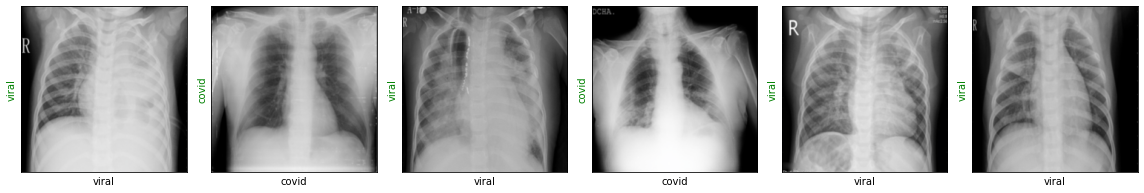

Evaluating at step 320
Validation Loss: 0.1492, Accuracy: 0.9778


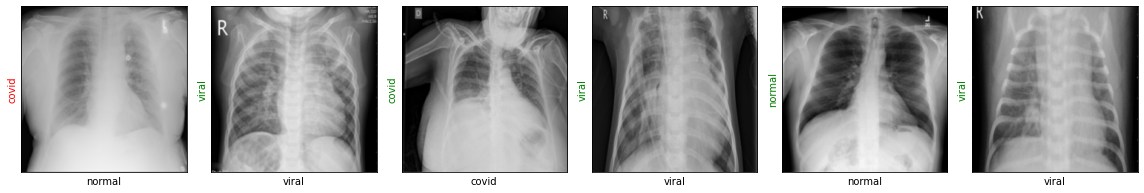

Performance condition satisfied, stopping..
CPU times: user 11min 8s, sys: 11.3 s, total: 11min 20s
Wall time: 25min 16s


In [75]:
%%time

train(epochs=1)

## Resultats finaux 

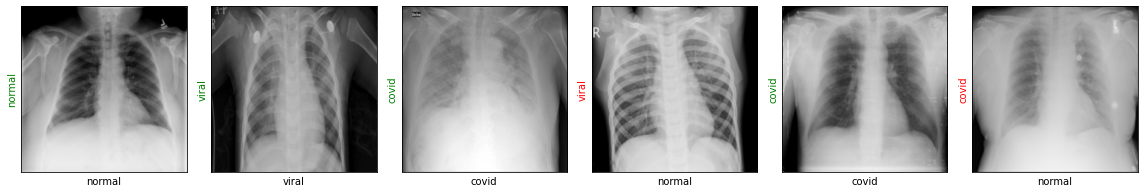

In [81]:
show_preds()
